![alt text](https://engmrk.com/wp-content/uploads/2018/09/LeNet_Original_Image.jpg)

![alt text](https://engmrk.com/wp-content/uploads/2018/09/LeNEt_Summary_Table.jpg)

In [0]:
import torch
import random
import numpy as np
%matplotlib inline
from IPython import display


random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [0]:
import torchvision.datasets

In [0]:
MNIST_train = torchvision.datasets.MNIST('./', download=False, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=False, train=False)

In [4]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [5]:
len(y_train), len(y_test)

(60000, 10000)

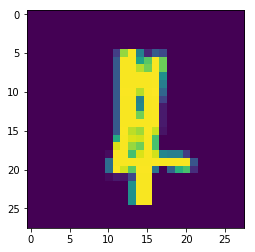

tensor(4)


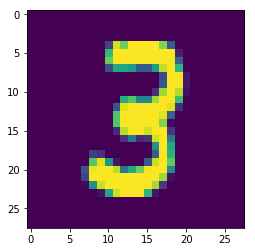

tensor(3)


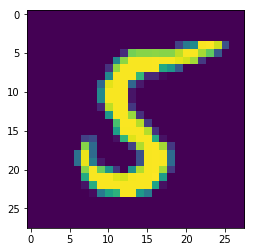

tensor(5)


In [6]:
import matplotlib.pyplot as plt
z = random.randint(0, 60000)
for i in range(z, z+3):
    plt.imshow(X_train[i, :, :])
    plt.show()
    print(y_train[i])

In [0]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [8]:
X_train.shape

torch.Size([60000, 1, 28, 28])

In [0]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=16, kernel_size=5, padding=2)
        self.act1  = torch.nn.LeakyReLU(inplace = True)
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
       
        self.conv2 = torch.nn.Conv2d(
            in_channels=16, out_channels=36, kernel_size=5, padding=0)
        self.act2  = torch.nn.LeakyReLU(inplace = True)
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.fc1   = torch.nn.Linear(5 * 5 * 36, 150)
        self.act3  = torch.nn.LeakyReLU(inplace = True)

        self.fc2   = torch.nn.BatchNorm1d(150)
        self.act4  = torch.nn.Dropout(p = 0.4)
        
        self.fc3   = torch.nn.Linear(150, 10)
        
        self.sm = torch.nn.Softmax(dim=1)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
#        x = self.act3(x)
        
        x = self.fc2(x)
        x = self.act4(x)
        x = self.act3(x)        
        x = self.fc3(x)
        
        return x

    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x
    
lenet5 = LeNet5()

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = lenet5.to(device)

In [0]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=2.5e-4)

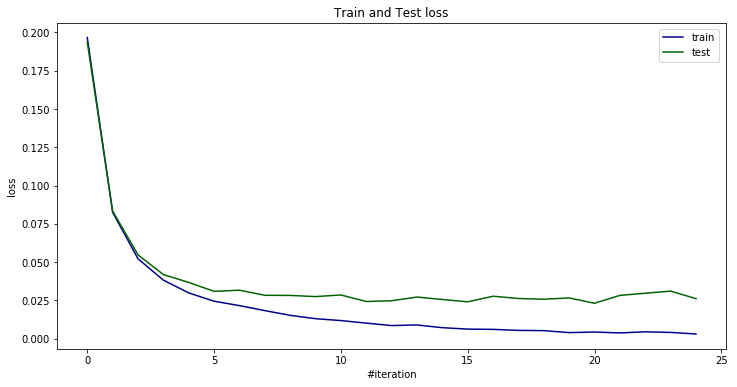

In [12]:
import numpy as np 

batch_size = 200
test_accuracy_history = []
test_loss_history = []
train_loss_history = []
X_test = X_test.to(device)
y_test = y_test.to(device)

X_train = X_train.to(device)
y_train = y_train.to(device)
for epoch in range(25):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes]#.to(device)
        y_batch = y_train[batch_indexes]#.to(device)
        
        preds = lenet5.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        optimizer.step()

    test_preds = lenet5.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).data.cpu())

    train_preds = lenet5.forward(X_train)
    train_loss_history.append(loss(train_preds, y_train).data.cpu())
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)
    
    display.clear_output(wait=True)
    plt.figure(figsize=(12, 6))        
    plt.title("Train and Test loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(train_loss_history, 'b', color = 'darkblue', label="train")
    plt.plot(test_loss_history, 'b', color = 'darkgreen', label="test")
    plt.legend(bbox_to_anchor=(0.9, 0.88), loc=3, borderaxespad=0.)
    plt.show()

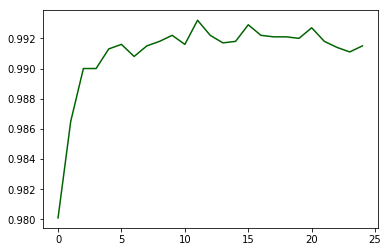

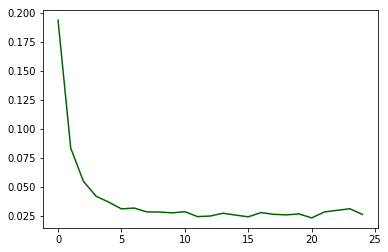

In [13]:
plt.plot(test_accuracy_history, 'b', color = 'darkgreen')
plt.show()
plt.plot(test_loss_history, 'b', color = 'darkgreen')
plt.show()

In [14]:
test_preds = lenet5.inference(X_test)
(test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()

tensor(0.9922)